In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext, Row
import pandas as pd
import numpy as np

# 반환값이 컬럼객체다
from pyspark.sql.functions import when, udf, col, regexp_replace
from pyspark.sql.types import DoubleType,IntegerType, StringType

In [2]:
sc = SparkContext( 'local' ) # spark://ip:7070 -> 분산 클러스터 이용가능 
sqlCtx = SQLContext( sc )

In [5]:
df = sqlCtx.read.csv( path   = '../data/crime_in_Seoul.csv',
                      header = False,
                      encoding = 'euc-kr',
                      inferSchema = True # shcema 자동 추정,
                    )

In [ ]:
df = sqlCtx.read.csv( path   = '../data/crime_in_Seoul.csv')

In [ ]:
df

##  (1) 컬럼명 변경
- withColumnsRenamed( '기존 컬럼명', '새로운 컬럼명' )

In [15]:
df = df.withColumnRenamed( '_c0','year').\
        withColumnRenamed( '_c1','boys').\
        withColumnRenamed( '_c2','girls')

In [17]:
df.head(5) # 결과값은 row

[Row(year=1880, boys=90993.0, girls=110491.0),
 Row(year=1881, boys=91954.0, girls=100745.0),
 Row(year=1882, boys=107850.0, girls=113688.0),
 Row(year=1883, boys=112321.0, girls=104629.0),
 Row(year=1884, boys=129022.0, girls=114445.0)]

In [18]:
df.show(5) # 결과값은 DataFrame

+----+--------+--------+
|year|    boys|   girls|
+----+--------+--------+
|1880| 90993.0|110491.0|
|1881| 91954.0|100745.0|
|1882|107850.0|113688.0|
|1883|112321.0|104629.0|
|1884|129022.0|114445.0|
+----+--------+--------+
only showing top 5 rows



In [19]:
df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- boys: double (nullable = true)
 |-- girls: double (nullable = true)



## (2) 연습문제
1. 2000년도 이후 데이터를 구하시요
2. 1995~2000 년도 데이터를 구하시요
3.  남아출생이 가장많은 top5를 
구하시요(년도,남아수 출력)
4. 남아율(%)컬럼을 추가하고 각년도별
남아수가 차지하는 비율을 보여주시요
5. 2000년도 이후 데이터를 바차트로 보여주시요

In [22]:
# 1. 2000년도 이후 데이터를 구하시요
df.where(" `year` >= 2000 " ).show()

+----+---------+---------+
|year|     boys|    girls|
+----+---------+---------+
|2000|1814601.0|1962406.0|
|2001|1799049.0|1941251.0|
|2002|1795206.0|1939815.0|
|2003|1825359.0|1973434.0|
|2004|1834145.0|1982794.0|
|2005|1845379.0|1994841.0|
|2006|1898463.0|2052377.0|
|2007|1919408.0|2072139.0|
|2008|1887234.0|2036289.0|
|2009|1832925.0|1979303.0|
|2010|1772738.0|1913851.0|
|2011|1753500.0|1893230.0|
+----+---------+---------+



In [23]:
# 2. 1995~2000 년도 데이터를 구하시요
df.where(" `year` between 1995 and 2000" ).show()

+----+---------+---------+
|year|     boys|    girls|
+----+---------+---------+
|1995|1757927.0|1902832.0|
|1996|1752249.0|1893378.0|
|1997|1739806.0|1884122.0|
|1998|1765915.0|1910250.0|
|1999|1772632.0|1918809.0|
|2000|1814601.0|1962406.0|
+----+---------+---------+



In [26]:
# 3. 남아출생이 가장많은 top5를 구하시요(년도,남아수 출력)
df.orderBy('boys', ascending=0).select('year','boys').show(5)

+----+---------+
|year|     boys|
+----+---------+
|1957|2044160.0|
|1959|2023044.0|
|1960|2022093.0|
|1961|2017316.0|
|1958|2010884.0|
+----+---------+
only showing top 5 rows



In [45]:
# 4. 남아율(%)컬럼을 추가하고 각년도별 남아수가 차지하는 비율을 보여주시요
df.withColumn( '남아율(%)', ( df['boys']/ (df['boys']+df['girls']) ) ).show()

+----+--------+--------+-------------------+
|year|    boys|   girls|          남아율(%)|
+----+--------+--------+-------------------+
|1880| 90993.0|110491.0| 0.4516140239423478|
|1881| 91954.0|100745.0|0.47718981416613476|
|1882|107850.0|113688.0| 0.4868239308831893|
|1883|112321.0|104629.0| 0.5177275870016133|
|1884|129022.0|114445.0| 0.5299362952679418|
|1885|133055.0|107800.0| 0.5524278092628345|
|1886|144535.0|110784.0| 0.5660957468891857|
|1887|145982.0|101414.0| 0.5900742130026354|
|1888|178627.0|120853.0| 0.5964571924669427|
|1889|178366.0|110584.0|  0.617290188613947|
|1890|190377.0|111025.0| 0.6316381444051467|
|1891|185482.0|101196.0| 0.6470046533044043|
|1892|212346.0|122037.0| 0.6350382645050735|
|1893|212906.0|112317.0| 0.6546461966097109|
|1894|222922.0|115772.0| 0.6581811310504467|
|1895|233630.0|117398.0| 0.6655594425515913|
|1896|237920.0|119570.0| 0.6655291057092506|
|1897|234202.0|112758.0| 0.6750115287064792|
|1898|258770.0|122693.0| 0.6783619905469207|
|1899|233023.

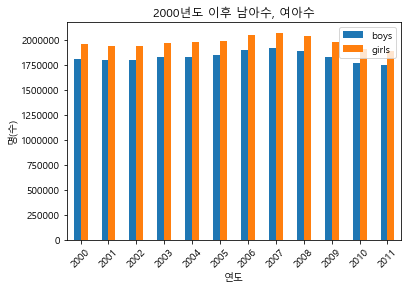

In [51]:
# 5.
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.family']='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] = False

aft_2000 = df.where(" `year` >= 2000 " ).toPandas()
aft_2000 = aft_2000.set_index('year')


aft_2000.plot( kind='bar',
               title= '2000년도 이후 남아수, 여아수', 
               rot = 45, 
           
             )

plt.xlabel('연도')
plt.ylabel('명(수)')

plt.show()

## (3) 통계값 구하기 
### AGG사용 
- 딕셔너리 타입으로 주기
    - 사용 가능한 함수
        - https://rfriend.tistory.com/213
- import 할 때 function들을 불러오기

In [57]:
import pyspark.sql.functions as F

In [56]:
df.agg( {"boys": "max"} ).withColumnRenamed( 'max(boys)','남아수 최대').show()

+-----------+
|남아수 최대|
+-----------+
|  2044160.0|
+-----------+



### boys sum()을 구하는 방법

In [76]:
# Sol(1)
df.agg( F.sum(df['boys']) ).toPandas() # 결과값은 Pandas

,sum(boys)
0,161802441.0


In [77]:
# Sol(2)
df.agg( F.sum(df['boys']) ).collect() # 결과값은 Row 

[Row(sum(boys)=161802441.0)]

In [63]:
# Sol(3)
df.agg( F.sum(df['boys']) ).show() # 결과값은 DataFrame

+------------+
|   sum(boys)|
+------------+
|1.61802441E8|
+------------+



In [81]:
df.agg( F.sum(df['boys']) ).toPandas().loc[0][0] # sum만 출력

161802441.0

In [70]:
df.agg( F.sum(df['boys']) ).collect()[0]['sum(boys)'] # sum만 출력

161802441.0

In [89]:
df.agg( F.sum('girls'), F.mean('boys') ).show()

+------------+------------------+
|  sum(girls)|         avg(boys)|
+------------+------------------+
|1.64392696E8|1225776.0681818181|
+------------+------------------+



In [92]:
df.agg( {'girls': 'stddev', 'boys': 'stddev'}).show()

+-----------------+-----------------+
|     stddev(boys)|    stddev(girls)|
+-----------------+-----------------+
|645550.2274655179|740002.8662878576|
+-----------------+-----------------+



In [104]:
r = df.agg( {'girls': 'stddev', 'boys': 'stddev'}).collect()[0]
print( '남아 표준편차', r[0] )
print( '여아 표준편차', r[1] )

남아 표준편차 645550.2274655179
여아 표준편차 740002.8662878576


In [113]:
df.agg( F.sum('girls').alias('여아 총합'), F.mean('girls').alias('여아 평균')).show()

+------------+------------------+
|   여아 총합|         여아 평균|
+------------+------------------+
|1.64392696E8|1245399.2121212122|
+------------+------------------+



In [114]:
df.agg( F.sum('girls').alias('여아 총합'), F.mean('girls').alias('여아 평균')).collect()

[Row(여아 총합=164392696.0, 여아 평균=1245399.2121212122)]